![](./images/banner.jpeg)
Photo by <a href="https://unsplash.com/@towfiqu999999?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Towfiqu barbhuiya</a> on <a href="https://unsplash.com/s/photos/customer-ratings?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
# I HATE this Product! Five Stars!
### Reducing Rating Inflation Using NLP
Author: Tom Chapman | [email](mailto:thomas.h.chapman@gmail.com) | [linkedin](https://www.linkedin.com/in/thomashchapman/) | [github](https://github.com/ThomasHChapman)

Most online marketplaces use 5-star product rating systems which are prone to rating inflation, obscuring product quality and customer sentiment. In addition to being problematic for the consumer, rating inflation makes it difficult for sellers to parse customer feedback and understand how their products are being received by the public. My project uses natural language processing to train a model on review sentiment so that it can be used to accurately classify customer reviews based on their content.


## Business Understanding
Since their inception, online marketplaces have fundamentally shifted how consumers shop. With a near limitless number of products and services available online, it has never been easier to avoid the hassle of brick-and-mortar stores. However, identifying which products or services are high-quality has become increasingly difficult. The popularity of the 5-star rating scale has led to a number of well-documented challenges. [Harvard Business Review](https://hbr.org/2019/07/the-problems-with-5-star-rating-systems-and-how-to-fix-them) summed these challenges up nicely as follows:

- There is little incentive for consumers to provide truthful feedback, meaning that extreme experiences (whether positive or negative) are much more likely to lead a consumer to leave a review.
- Compounding the lack of incentive for truth, 5-star rating scales are prone to grade inflation. There is no correlation between the star-rating and the sentiment the user expresses in a review. It's possible (and surprisingly common) for a user to hate a product, excoriate it in a review, and then rate it 5-stars. This leads to inflated ratings, and makes it harder for the consumer to understand the meaning behind varied product ratings. How much better is a product with a 4.7 star rating than a 4.5 star average rating?
My model is intended to help address rating inflation by classifying user feedback as positive or negative based on its content.

Amazon is the largest online marketplace currently in existence, and its challenges with rating inflation are [common knowledge](https://www.nytimes.com/2021/06/18/technology/amazon-reviews.html). However, any marketplace that uses a five-star rating system (Google Play, Apple App Store, Chewy, Wal-mart, Etsy, Rakuten, etc.) can utilize my model to reclassify user reviews into positive or negative polarity. Offering customers a clearer display of product quality allows customers to make more informed purchases, and should drive improved satisfaction. It should also help mitigate poor quality or scam sellers inherently, as poor reviews are less likely to be drowned out by inflated ratings.

The tool is also useful for sellers that want to move away from Amazon or implement their own storefront. By implementing my algorithm in a newly-created storefront, sellers can mostly automate the classification of consumer feedback and derive a more accurate understanding of how their products or services are being received. On average, Amazon sellers pay the website about 15% of their sale price on each item sold. There's no question the visibility and customer reach that Amazon provides is valuable, but 15% is an extremely hefty cost for small companies. For certain product categories, the cost per item can range as high as 45%, an enormous amount to pay simply for the storefront component of the site.

## Data Preparation
Because of the enormity of the dataset, all substantive data cleaning was performed in [the cleaning notebook](preprocessing_nb.ipynb). The data preparation section in this notebook will be limited to importing necessary packages, reading in our pre-cleaned data, and dropping any null values.

In [102]:
# Package Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import ParameterGrid, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from imblearn.pipeline import Pipeline as ImPipeline

import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

In [103]:
# Read in the data & preview its contents
df = pd.read_csv('../data/train_cleaned_10sw.csv', index_col=0)
df.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
df.info()

In [ ]:
# Review target variable distribution
df['sentiment'].value_counts()

In [ ]:
# Find & Display any NaN values for cleaned text 
print(df.isna().sum())
df[df['text_cleaned'].isna()]

In [ ]:
# Drop rows with missing text_cleaned values
df.dropna(inplace=True)

In [ ]:
# Save off feature combinations for use in model iteration
X = df['text_cleaned']

X_bigrams = df[['text_cleaned', 'bigrams']]
X_trigrams = df[['text_cleaned', 'trigrams']]
X_allgrams = df[['text_cleaned', 'bigrams', 'trigrams']]

y = df['sentiment']

# Modeling
I utilized a number of sklearn's modeling techniques for the project. As noted in the data-preparation description, I experimented with the inclusion of bi-grams and tri-grams created from user input during the modeling process as well. I evaluated each model based on its accuracy score, as the real-world impact of a false positive or negative is quite low. With basic python it is easy to collect all the reviews that the classifier scores mislables for human review. Ultimately, a logistic regression classifier with default parameters was the best performer.

### Dummy Classifier
To begin modelling efforts, I built a dummy classifier that simply guesses the most common class every time. Given that our training data is almost (but not perfectly) balanced, we should expect it to predict that every review is negative since there are slightly more negative reviews than positive reviews. If we can't beat a 50-50 guess with a dataset this large, something is horribly wrong. Predictably, the dummy classifier achieved an accuracy score of almost exactly 50%.

In [ ]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                ('vect', TfidfVectorizer()),
                                ('cf', DummyClassifier(strategy='most_frequent',
                                                           random_state=42))
                              ]
)

In [ ]:
# Fit dummy pipe on the training data and plot confusion matrix
dummy_pipe.fit(X, y)
dummy_yhat = dummy_pipe.predict(X)
plot_confusion_matrix(dummy_pipe, X, y, normalize='true');
print(accuracy_score(y, dummy_yhat))

### Multinomial Naive Bayes
MNB is a commonly-used algorithm for natural language processing due to effectiveness in classifying topics while maintaining a low training time and relative simplicity. It predicts the probability that a given document belongs to a particular class based on the words it contains. I employed a multinomial naive bayes classifier as my first simple model for these reasons, and it will be the baseline model that I attempt to beat. 

In [ ]:
# Instantiate the Multinomial Naieve Bayes Pipeline
mnb_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer()),
                            ('cf', MultinomialNB())
                            ]
)

# Fit MNB pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X, y)
mnb_yhat = mnb_pipe.predict(X)
plot_confusion_matrix(mnb_pipe, X, y, normalize='true');
print(accuracy_score(y, mnb_yhat))

In [ ]:
# Obtained cross-validated accuracy score
mnb_cv = cross_validate(mnb_pipe, X, y)
print(mnb_cv)

- 'fit_time': 63.91176295, 64.27754903, 63.07658076, 62.96271181, 63.14784789
- 'score_time': 14.80177712, 14.56706309, 14.5999763 , 14.49988723, 14.33135796
- 'test_score': 0.81850038, 0.81476842, 0.81272648, 0.81008618, 0.81112924

In [ ]:
mnb_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
mnb_cr = classification_report(y, mnb_yhat, output_dict=True)

In [ ]:
# Define model_performance Dictionary for use in visualizations, add mean model result.
mod_perf = {}
mod_perf['mnb_1grams'] = mnb_cv['test_score'].mean()

#### Using N-grams as Features
To see if I could improve on the model's performance over using single words, I tried giving it bi-grams and tri-grams as additional features. Ultimately, the MNB classifier was most accurate using only single words from each review as its inputs.

##### Single Words & Bi-Grams

In [ ]:
# Instantiate the MNB Pipeline with cleaned text and bi-grams
mnb_bigrams_pipe = ImPipeline(steps=[
            ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                          'bigrams']
                                     ])),
            ('cf', MultinomialNB())
]
)

# Fit MNB pipe on the cleaned text and bi-grams, get predictions, plot confusion matrix
mnb_bigrams_pipe.fit(X_bigrams, y)
mnb_bigrams_yhat = mnb_bigrams_pipe.predict(X_bigrams)
plot_confusion_matrix(mnb_bigrams_pipe, X_bigrams, y, normalize='true');
print(accuracy_score(y, mnb_bigrams_yhat))

In [ ]:
# Obtained cross-validated accuracy score
mnb_bigrams_cv = cross_validate(mnb_bigrams_pipe, X_bigrams, y)
print(mnb_bigrams_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(mnb_bigrams_cv['test_score'].mean())
mod_perf['mnb_2grams'] = mnb_bigrams_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
mnb_bigram_cr = classification_report(y, mnb_bigrams_yhat, output_dict=True)

##### Single Words & Tri-Grams

In [ ]:
# Instantiate the Multinomial Naive Bayes Pipeline with clean text and tri-grams
mnb_trigrams_pipe = ImPipeline(steps=[
                ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                              'trigrams']
                                         ])),
                ('cf', MultinomialNB())
]
)

# Fit MNB pipe on the training data, get predictions and plot confusion matrix
mnb_trigrams_pipe.fit(X_trigrams, y)
mnb_trigrams_yhat = mnb_trigrams_pipe.predict(X_trigrams)
plot_confusion_matrix(mnb_trigrams_pipe, X_trigrams, y, normalize='true');
print(accuracy_score(y, mnb_trigrams_yhat))

In [ ]:
# Obtained cross-validated accuracy score
mnb_trigrams_cv = cross_validate(mnb_trigrams_pipe, X_trigrams, y)
print(mnb_trigrams_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(mnb_trigrams_cv['test_score'].mean())
mod_perf['mnb_3grams'] = mnb_trigrams_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
mnb_trigram_cr = classification_report(y, mnb_trigrams_yhat, output_dict=True)

##### Single Words, Bi-Grams & Tri-Grams

In [ ]:
# Instantiate the Multinomial Naieve Bayes pipeline with clean text, bi-grams and tri-grams
mnb_allgrams_pipe = ImPipeline(steps=[          
                ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                              'bigrams',
                                                                              'trigrams']
                                         ])),
                ('cf', MultinomialNB())
]
)

# Fit MNB pipe on the training data, get predictions and plot confusion matrix
mnb_allgrams_pipe.fit(X_allgrams, y)
mnb_allgrams_yhat = mnb_allgrams_pipe.predict(X_allgrams)
plot_confusion_matrix(mnb_allgrams_pipe, X_allgrams, y, normalize='true');
print(accuracy_score(y, mnb_allgrams_yhat))

In [ ]:
# Obtained cross-validated accuracy score
mnb_allgrams_cv = cross_validate(mnb_allgrams_pipe, X_allgrams, y)
print(mnb_allgrams_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(mnb_allgrams_cv['test_score'].mean())
mod_perf['mnb_allgrams'] = mnb_allgrams_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
mnb_allgram_cr = classification_report(y, mnb_allgrams_yhat, output_dict=True)

### Logistic Regression
Logistic Regression is a common step in any binary classification problem, so I elected to use it as my next modeling approach. It is a linear classification method that learns the probability of an observation belonging to a target class, and then finds the decision boundary that best separates the classes. It splits feature space linearly and typically works well even when there is correlation among the variables, as is the case in our dataset. Because the data is made up of consumer reviews, it is likely that similar language patterns may be observed throughout.

Right away, we see a significant (5.6%) improvement in accuracy over our best-performing Naive Bayes model. By including tri-grams of our corpus along with single words, we see a performance gain of 5.8% over our best Naive Bayes model.

In [ ]:
# Instantiate the Logistic Regression Pipeline
logreg_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer()),                              
                                 ('lr', LogisticRegression(n_jobs=-2))
                                ]
)


# Fit Logistic Regression pipeline on the training data, get predictions and plot confusion matrix
logreg_pipe.fit(X, y)
logreg_yhat = logreg_pipe.predict(X)
plot_confusion_matrix(logreg_pipe, X, y, normalize='true');
print(accuracy_score(y, logreg_yhat))

In [ ]:
# Obtained cross-validated accuracy score
logreg_cv = cross_validate(logreg_pipe, X, y)
print(logreg_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(logreg_cv['test_score'].mean())
mod_perf['logreg_1grams'] = logreg_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
logreg_cr = classification_report(y, logreg_yhat, output_dict=True)

In [ ]:
with open ('../models/10sw/sw_logreg_base.pkl', 'wb') as files:
    joblib.dump(logreg_pipe, files)

#### Using N-grams as Features
To see if I could improve on the model's performance over using single words, I tried giving it bi-grams and tri-grams as additional features. This time, the combination of single words and tri-grams proved to be the best performer of the group, with a cross-validated accuracy score of 87.14%.

##### Single Words & Bi-Grams

In [ ]:
# Instantiated the Logistic Regression Pipeline with clean text and bi-grams
logreg_bigram_pipe = ImPipeline(steps=[
                ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                              'bigrams']
                                         ])),                             
                ('lr', LogisticRegression(n_jobs=-2))
]
)


# Fit Logistic Regression pipeline on the training data, get predictions and plot confusion matrix
logreg_bigram_pipe.fit(X_bigrams, y)
logreg_bigram_yhat = logreg_bigram_pipe.predict(X_bigrams)
plot_confusion_matrix(logreg_bigram_pipe, X_bigrams, y, normalize='true');
print(accuracy_score(y, logreg_bigram_yhat))

In [ ]:
# Obtained cross-validated accuracy score
logreg_bigram_cv = cross_validate(logreg_bigram_pipe, X_bigrams, y)
print(logreg_bigram_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(logreg_bigram_cv['test_score'].mean())
mod_perf['logreg_2grams'] = logreg_bigram_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
logreg_bigram_cr = classification_report(y, logreg_bigram_yhat, output_dict=True)

##### Single Words & Tri-Grams

In [ ]:
# Instantiate the Logistic Regression Pipeline with clean text and tri-grams
logreg_trigram_pipe = ImPipeline(steps=[
                ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                              'trigrams']
                                         ])),                             
                ('lr', LogisticRegression(n_jobs=-2))
]
)


# Fit LogReg pipeline on the training data, get predictions and plot confusion matrix
logreg_trigram_pipe.fit(X_trigrams, y)
logreg_trigram_yhat = logreg_trigram_pipe.predict(X_trigrams)
plot_confusion_matrix(logreg_trigram_pipe, X_trigrams, y, normalize='true');
print(accuracy_score(y, logreg_trigram_yhat))

In [ ]:
# Obtained cross-validated accuracy score
logreg_trigram_cv = cross_validate(logreg_trigram_pipe, X_trigrams, y)
print(logreg_trigram_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(logreg_trigram_cv['test_score'].mean())
mod_perf['logreg_3grams'] = logreg_trigram_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
logreg_trigram_cr = classification_report(y, logreg_trigram_yhat, output_dict=True)

In [ ]:
# Save model for future use
with open('../models/10sw/sw_logreg_trigram_model.pkl', 'wb') as files:
    joblib.dump(logreg_trigram_pipe, files)

##### Single Words, Bi-Grams & Tri-Grams

In [ ]:
# Instantiate the LR Pipeline with clean text, bi-grams and tri-grams
logreg_allgram_pipe = ImPipeline(steps=[
                ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                              'bigrams',
                                                                              'trigrams']
                                         ])),                             
                ('lr', LogisticRegression(n_jobs=-2))
]
)


# Fit Logistic Regression pipeline on the training data, get predictions and plot confusion matrix
logreg_allgram_pipe.fit(X_allgrams, y)
logreg_allgram_yhat = logreg_allgram_pipe.predict(X_allgrams)
plot_confusion_matrix(logreg_allgram_pipe, X_allgrams, y, normalize='true');
print(accuracy_score(y, logreg_allgram_yhat))

In [ ]:
# Obtained cross-validated accuracy score
logreg_allgram_cv = cross_validate(logreg_allgram_pipe, X_allgrams, y)
print(logreg_allgram_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(logreg_allgram_cv['test_score'].mean())
mod_perf['logreg_allgrams'] = logreg_allgram_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
logreg_allgram_cr = classification_report(y, logreg_allgram_yhat, output_dict=True)

In [ ]:
# Save model for future use
with open('../models/10sw/sw_logreg_allgram_model.pkl', 'wb') as files:
    joblib.dump(logreg_allgram_pipe, files)

### Linear Support Vector Machine - Stochastic Gradient Descent
Stochastic gradient descent is another technique that is very common in natural language processing due to its efficiency. Rather than calculating the gradient at each iteration using every observation in the dataset, it selects one observation at random for each step, drastically reducing the computational requirements. It uses linear models, similar to logistic regression, but performs gradient descent in a random (Stochastic) manner. It also works very well with sparse data, which makes it a natural fit for NLP. Given the size of my dataset, efficiency is very valuable and so SGD was a natural next step.

In [ ]:
# Instantiate the SGDC Classifier pipeline
sgdc_pipe = ImPipeline(steps=[
                            ('vect', TfidfVectorizer()),
                            ('cf', SGDClassifier(random_state=42))
                            ]
)

#Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_pipe.fit(X, y)
sgdc_yhat = sgdc_pipe.predict(X)
plot_confusion_matrix(sgdc_pipe, X, y, normalize='true');
print(accuracy_score(y, sgdc_yhat))

In [ ]:
# Obtained cross-validated accuracy score
sgdc_cv = cross_validate(sgdc_pipe, X, y)
print(sgdc_cv)

- 'fit_time': array([70.02949595, 70.80230594, 70.30221891, 70.43828201, 70.43610787])
- 'score_time': array([14.75940609, 14.66371202, 14.59122682, 14.39158106, 14.41444707])
- 'test_score': array([0.84893944, 0.84923944, 0.85029202, 0.85031702, 0.85053785])

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(sgdc_cv['test_score'].mean())
mod_perf['sgdc_1grams'] = sgdc_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
sgdc_cr = classification_report(y, sgdc_yhat, output_dict=True)

In [ ]:
# Save pickled model
with open ('../models/10sw/sw_sgdc_base.pkl', 'wb') as files:
    joblib.dump(sgdc_pipe, files)

#### Using N-grams as Features 
To see if I could improve on the model's performance over using single words, I tried giving it bi-grams and tri-grams as additional features. Ultimately, the model realized a small accuracy gain of 0.0062 by showing it bi-grams and tri-grams in addition to single words. The sgd classifier did not outperform logistic regression with the settings used.

##### Single Words & Bi-Grams

In [ ]:
# Instantiate the SGDC pipeline with cleaned text and bi-grams
sgdc_bigrams_pipe = ImPipeline(steps=[
                ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                              'bigrams']
                                         ])),
                ('cf', SGDClassifier(random_state=42))
]
)

# Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_bigrams_pipe.fit(X_bigrams, y)
sgdc_bigrams_yhat = sgdc_bigrams_pipe.predict(X_bigrams)
plot_confusion_matrix(sgdc_bigrams_pipe, X_bigrams, y, normalize='true');
print(accuracy_score(y, sgdc_bigrams_yhat))

In [ ]:
sgdc_bigrams_cv = cross_validate(sgdc_bigrams_pipe, X_bigrams, y)
print(sgdc_bigrams_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(sgdc_bigrams_cv['test_score'].mean())
mod_perf['sgdc_2grams'] = sgdc_bigrams_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
sgdc_bigrams_cr = classification_report(y, sgdc_bigrams_yhat, output_dict=True)

##### Single Words & Tri-Grams

In [ ]:
# Instantiate the SGDC pipeline with clean text and tri-grams
sgdc_trigrams_pipe = ImPipeline(steps=[
                ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                              'trigrams']
                                                             ])),                             
                ('cf', SGDClassifier(random_state=42))
]
)

# Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_trigrams_pipe.fit(X_trigrams, y)
sgdc_trigrams_yhat = sgdc_trigrams_pipe.predict(X_trigrams)
plot_confusion_matrix(sgdc_trigrams_pipe, X_trigrams, y, normalize='true');
print(accuracy_score(y, sgdc_trigrams_yhat))

In [ ]:
sgdc_trigrams_cv = cross_validate(sgdc_trigrams_pipe, X_trigrams, y)
print(sgdc_trigrams_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(sgdc_trigrams_cv['test_score'].mean())
mod_perf['sgdc_3grams'] = sgdc_trigrams_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
sgdc_trigrams_cr = classification_report(y, sgdc_trigrams_yhat, output_dict=True)

##### Single Words, Bi-Grams & Tri-Grams

In [ ]:
# Instantiate the SGDC pipeline with clean text, bi-grams and tri-grams
sgdc_allgrams_pipe = ImPipeline(steps=[
                ('CT', ColumnTransformer([(x, TfidfVectorizer(), x) for x in ['text_cleaned',
                                                                              'bigrams',
                                                                              'trigrams']
                                                             ])),                             
                ('cf', SGDClassifier(random_state=42))
]
)

# Fit SGDC pipe on the training data, get predictions and plot confusion matrix
sgdc_allgrams_pipe.fit(X_allgrams, y)
sgdc_allgrams_yhat = sgdc_allgrams_pipe.predict(X_allgrams)
plot_confusion_matrix(sgdc_allgrams_pipe, X_allgrams, y, normalize='true');
print(accuracy_score(y, sgdc_allgrams_yhat))

In [ ]:
# Obtained cross-validated accuracy score
sgdc_allgrams_cv = cross_validate(sgdc_allgrams_pipe, X_allgrams, y)
print(sgdc_allgrams_cv)

In [ ]:
# Print cross-validated mean accuracy score & add to model performance dictionary
print(sgdc_allgrams_cv['test_score'].mean())
mod_perf['sgdc_allgrams'] = sgdc_allgrams_cv['test_score'].mean()

In [ ]:
# Stored classification report for comparison
sgdc_allgrams_cr = classification_report(y, sgdc_allgrams_yhat, output_dict=True)

In [ ]:
# Save pickled model
with open ('../models/10sw/sw_sgdc_allgrams.pkl', 'wb') as files:
    joblib.dump(sgdc_allgrams_pipe, files)

#### Visualizing Model Performance

In [ ]:
# Create dataframe of model performance using the mod_perf dictionary
mod_perf_df = pd.DataFrame.from_dict(mod_perf, orient='index')
mod_perf_df.reset_index(inplace=True)
mod_perf_df.columns = ['model', 'accuracy']

# Save model performance to disk for future use, given long execution time for the notebook.
mod_perf_df.to_csv('../data/model_performance.csv')

In [ ]:
mod_perf

In [ ]:
# Visualization of Model Perforamnce

# Read model performance from csv
mod_perf_df = pd.read_csv('../data/model_performance.csv', index_col=0)

# Set custom colorblind-friendly colors
colors = [[86/255,180/255,233/255], [86/255,180/255,233/255], [86/255,180/255,233/255],
         [86/255,180/255,233/255], [86/255,180/255,233/255], [86/255,180/255,233/255],
         [0,158/255,115/255], [86/255,180/255,233/255], [86/255,180/255,233/255],
         [86/255,180/255,233/255], [86/255,180/255,233/255], [86/255,180/255,233/255]]

# Plot Bar Graph
fig, ax = plt.subplots(figsize=(10,10))
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 13})
plt.axis([None, None, 0.8, 0.88])

ax.bar(mod_perf_df['model'], mod_perf_df['accuracy'], color=colors)
ax.set_title('Model Performance by Cross-validated Accuracy Score')
ax.set_ylabel('Accuracy Score (%)', labelpad=10)
ax.set_xlabel('Model Variety', labelpad=10)
ax.set_yticklabels(labels = ['80', '81', '82', '83', '84', '85', '86', '87', '88'])
ax.tick_params(axis="x", rotation=90)
plt.tight_layout()

# Save figure to file for use in presentation
#plt.savefig('../images/model_performance.png', dpi=500)

## Final Model Evaluation
The logistic regression model that trained on a combination of 1-grams and 3-grams had the highest accuracy score, so I selected it as the appropriate model for this task. The model's accuracy was only very slightly (0.0004) better than a similarly-configured model that received 1-grams, 2-grams and 3-grams. However slight the margin, when combined with the fact that it requires significantly less data and therefore a shorter cleaning process, its superiority becomes clear.

The model appears to generalize quite well, as it produced an accuracy score of 87.19% on completely unseen data, as compared to cross-validated accuracy of 87.14% on the training data. It correctly classified 88% of positive reviews and 87% of negative reviews in the test data, suggesting that it is slightly more accurate at determining positive sentiment than negative sentiment. The model avoids significant weaknesses with false positives or negatives, and significantly reduces the number of reviews that would require human review in a real-world setting. Particularly for sellers that wish to set up their own online storefront, the model’s efficiency is highly appealing.

The primary weakness of my model lies in its performance relative to more sophisticated NLP algorithms. There are a number of highly accurate classifiers available, and NLP as a field is advancing rapidly. However, more advanced techniques can require compute resources that may not be available to small sellers for budgetary or technical literacy reasons. My model is small enough to be deployed in a web application for easy upload/download of customer reviews and classification. It could be improved upon by a large marketplace with the financial and technical resources to tune its hyperparameters, though it is likely that an organization with those resources could implement a more sophisticated and accurate model.

### Prepare Test Data
The process below follows the same process as the training data.

In [ ]:
# Read in the test data
df_test = pd.read_csv('../data/test_cleaned_10sw.csv', index_col=0)

In [ ]:
# Find & Display any NaN values for cleaned text 
print(df_test.isna().sum())
df_test[df_test['text_cleaned'].isna()]

In [ ]:
# Drop the single NaN row
df_test.dropna(inplace=True)

In [ ]:
# Save off feature combinations as required for use in the final model.
X_test_trigrams = df_test[['text_cleaned', 'trigrams']]
y_test = df_test['sentiment']

### Load & Score Final Model

In [137]:
# Load best-performing model from file
with open('../models/10sw/sw_logreg_trigram_model.pkl', 'rb') as f:
    logreg_trigram_pipe = joblib.load(f)

0.8718815391115433


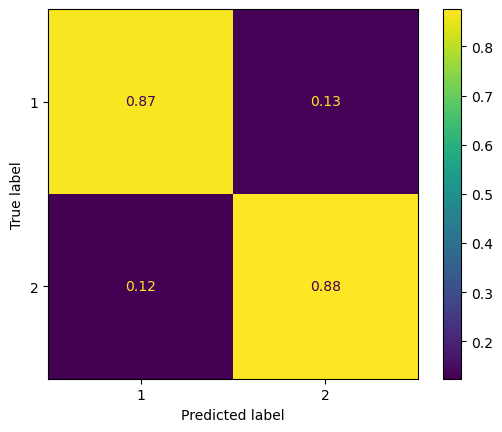

In [138]:
# Score the final model on the test data & plot confusion matrix
print(logreg_trigram_pipe.score(X_test_trigrams, y_test))
plt.style.use('default')
plot_confusion_matrix(logreg_trigram_pipe, X_test_trigrams, y_test, normalize='true');

In [139]:
# Make predictions and print classification report for visual inspection
yhat_test = logreg_trigram_pipe.predict(X_test_trigrams)
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           1       0.87      0.87      0.87    200000
           2       0.87      0.88      0.87    199997

    accuracy                           0.87    399997
   macro avg       0.87      0.87      0.87    399997
weighted avg       0.87      0.87      0.87    399997



### Testing reviews from reddit

In [151]:
# Read in the reddit data 
df_reddit = pd.read_csv('../data/reddit_cleaned.csv')

# Save features to appropriate variable & visually inspect
X_red_trigrams = df_reddit[['text_cleaned', 'trigrams']]
X_red_trigrams

,text_cleaned,trigrams
0,amp x b kingston datatraveler exodia affordabl...,"[('amp', 'x', 'b'), ('x', 'b', 'kingston'), ('..."
1,amp x b brita flow water tank design filter ta...,"[('amp', 'x', 'b'), ('x', 'b', 'brita'), ('b',..."
2,degree motionsense antiperspirant deodorant dr...,"[('degree', 'motionsense', 'antiperspirant'), ..."
3,think negative review write site display i'll ...,"[('think', 'negative', 'review'), ('negative',..."
4,chance use taotronics active noise cancel head...,"[('chance', 'use', 'taotronics'), ('use', 'tao..."
5,free item u nitrile disposable glove pcs inter...,"[('free', 'item', 'u'), ('item', 'u', 'nitrile..."
6,review different tech product every week join ...,"[('review', 'different', 'tech'), ('different'..."
7,percussion massager massage gun extremely usef...,"[('percussion', 'massager', 'massage'), ('mass..."
8,use thymuskin hair shampoo serum medium month ...,"[('use', 'thymuskin', 'hair'), ('thymuskin', '..."
9,rarely review anything except book excellent p...,"[('rarely', 'review', 'anything'), ('review', ..."


In [115]:
# Check for NaN values
df_reddit.isna().sum()

Unnamed: 0      0
index           0
subreddit       0
title           0
selftext        0
upvote_ratio    0
ups             0
downs           0
score           0
text_cleaned    0
bigrams         0
trigrams        0
dtype: int64

In [128]:
# Add a column to the X_red_trigrams dataframe containing the model's predictions for comparison
X_red_trigrams.insert(loc=2, column="sentiment", value=pd.Series(logreg_trigram_pipe.predict(X_red_trigrams)))
X_red_trigrams

### Testing Reviews from women's fashion dataset

In [145]:
# Read in the fashion data
df_fashion = pd.read_csv('../data/fashion_cleaned.csv')

# Save features & target to appropriate variables & visually inspect
X_fash_trigrams = df_fashion[['text_cleaned', 'trigrams']]
y_fash = df_fashion['sentiment']
X_fash_trigrams

In [147]:
X_fash_trigrams.isna().sum()

text_cleaned    0
trigrams        0
dtype: int64

0.8781915430416792


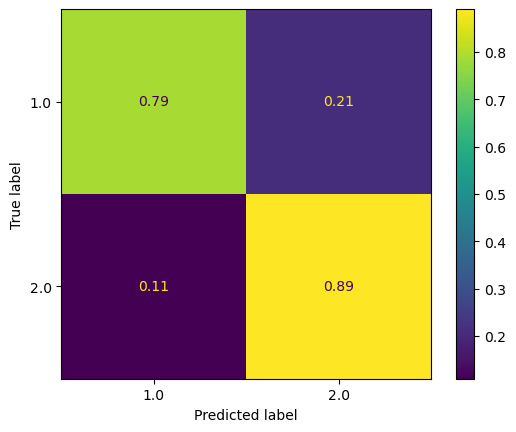

In [148]:
# Score the final model on the fashion data & plot confusion matrix
print(logreg_trigram_pipe.score(X_fash_trigrams, y_fash))
plt.style.use('default')
plot_confusion_matrix(logreg_trigram_pipe, X_fash_trigrams, y_fash, normalize='true');

In [150]:
# Make predictions and print classification report for visual inspection
yhat_fash = logreg_trigram_pipe.predict(X_fash_trigrams)
print(classification_report(y_fash, yhat_fash))

              precision    recall  f1-score   support

         1.0       0.49      0.79      0.61      2370
         2.0       0.97      0.89      0.93     17448

    accuracy                           0.88     19818
   macro avg       0.73      0.84      0.77     19818
weighted avg       0.91      0.88      0.89     19818



## Conclusion
The model was able to achieve solid accuracy scores and improve upon the baseline MNB model with limited tuning and a reasonable train time. The performance is thanks largely to the quality, size and balance of the dataset. I would recommend the model to businesses wishing to create their own storefronts in order to avoid rating inflation problems down the road. It has proven to be very accurate at classifying review sentiment, and it is relatively easy to identify a list of incorrect predictions with basic python that could be inspected by a human.

The model is likely less suited for large-scale deployment by Amazon or a similar marketplace, as there are superior options that exist, and large marketplaces have the resources to support the computational demands of more sophisticated models. In the case of Amazon, it’s likely to be cost-efficient to develop their own classifier that is constantly training on new user reviews as they happen. 

### Further Development
The next step in the project will be to refactor the cleaning & training code to be utilized in a web application. I envision the application providing a way for sellers that have previously used a storefront like Amazon or Rakuten to upload all of their review data and have it classified before leaving the site. Amazon famously does not provide an api for review data, so it will be up to the business to gather the data themselves. This functionality would help a business efficiently classify product sentiment at the time of transition, and form a baseline for their understanding to build from. 

From a legal perspective, a business would need written permission from each review author in order to actually transfer the reviews. That process will be horribly inefficient and likely not worth the trouble, especially for heavily-reviewed products. My tool provides a partial solution by helping businesses understand with a high degree of accuracy the proportion of their reviews that are actually positive or negative before transitioning away from the larger marketplace.

